## Load line 60T MRT model and INI1 re-expressioni

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 10.0 seconds
         Falling back to preprocessing with `sc.pp.pca` and default params.


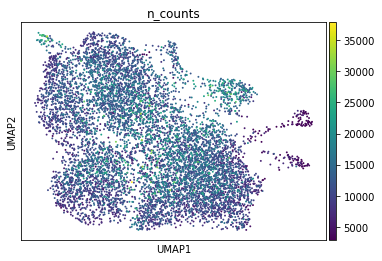

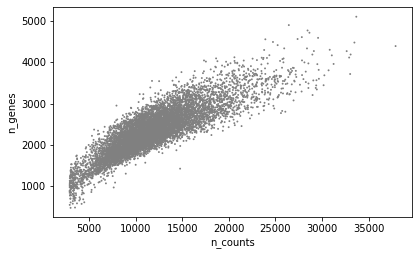

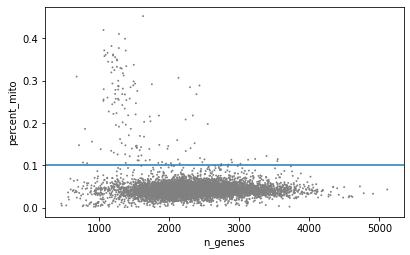

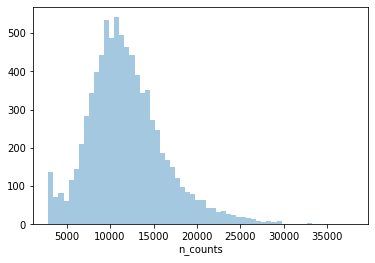

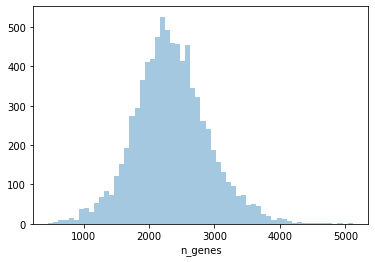

In [2]:
%matplotlib inline
import scrublet as scr
import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")


# function to apply scrublet to filter doublets 
def filter_doublets(adata):
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    return [adata[~predicted_doublets].copy(), np.where(predicted_doublets)[0]]


# function to do basic preprocessing and normalization of single cell data
# commonly used steps - following scanpy tutorial mostly
def simpleFiltering(adata):
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells = 3)
    sc.pp.filter_cells(adata, min_genes=200)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


# read cellranger output data for cell line 60T MRT model without SMARCB1 expression
# use the path to filtered_gene_bc_matrices folder
adata_mrt = sc.read_10x_mtx('MRT_data/MRT_60T_CTRL/', var_names='gene_symbols', cache=True)
# filter out residual cells with SMARCB1 expression
adata_mrt = adata_mrt[adata_mrt[:, 'SMARCB1'].X == 0]

adata_mrt, doublets60 = filter_doublets(adata_mrt)
adata_mrt = simpleFiltering(adata_mrt)

sc.pp.neighbors(adata_mrt)
sc.tl.umap(adata_mrt)
sc.pl.umap(adata_mrt, color = 'n_counts')

ax = sc.pl.scatter(adata_mrt, x='n_counts', y='n_genes', show=False)

ax2 = sc.pl.scatter(adata_mrt, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.1,0, 7000)
plt.show()

p1 = sb.distplot(adata_mrt.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_mrt.obs['n_genes'], kde=False, bins=60)


Same process for MRT model with INI1 reexpression

In [ ]:
# read cellranger output data for cell line 60T with SMARCB1 reexpression
adata_ini1 = sc.read_10x_mtx('MRT_data/MRT_60T_SMB/', var_names='gene_symbols', cache=True)
# here we filter the residual cells without SMARCB1 expression
adata_ini1 = adata_ini1[adata_ini1[:, 'SMARCB1'].X != 0]

adata_ini1, doublets60 = filter_doublets(adata_ini1)
adata_ini1 = simpleFiltering(adata_ini1)

sc.pp.neighbors(adata_ini1)
sc.tl.umap(adata_ini1)
sc.pl.umap(adata_ini1, color = 'n_counts')

ax = sc.pl.scatter(adata_ini1, x='n_counts', y='n_genes', show=False)

ax2 = sc.pl.scatter(adata_ini1, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.1,0, 7000)
plt.show()

p1 = sb.distplot(adata_ini1.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_ini1.obs['n_genes'], kde=False, bins=60)


As we can see, the fraction of mitochondrial reads is low in cell line 60T for MRT model and INI1 re-expression experiment  - most cells have less than 10% mito genes - this is a good sign, we going to filter mitochondrial cell with mito content less than 10%. 
The distribution of number of counts per cell and number of genes per cell looks good, both following gaussian distribution as expected.

In [ ]:
adata_mrt = adata_mrt[adata_mrt.obs.percent_mito<0.1]
print ('MRT after filtering mitochondrial contamination')
sc.pl.scatter(adata_mrt, x='n_genes', y='percent_mito')
p1 = sb.distplot(adata_mrt.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_mrt.obs['n_genes'], kde=False, bins=60)
plt.show()

print ('MRT with INI1 reexpression after filtering mitochondrial contamination')
adata_ini1 = adata_ini1[adata_ini1.obs.percent_mito<0.1]
sc.pl.scatter(adata_ini1, x='n_genes', y='percent_mito')
p1 = sb.distplot(adata_ini1.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_ini1.obs['n_genes'], kde=False, bins=60)

All looks good

## Now let's look at cell line 78T and 103T MRT model (no INI1 expression)
Cell lines 78T and 103T were multiplexed together, we used demuxlet to demultiplex them taking advantage of genotyping information in VCF format. Demuxlet produced lifted.best file that contains cluster assignments.

In [ ]:
# let's check MRT model without SMARCB1 expression first
adata_ctrl = sc.read_10x_mtx('MRT_data/MRT_78and103_CTRL/', var_names='gene_symbols', cache=True)
adata_ctrl = adata_ctrl[adata_ctrl[:, 'SMARCB1'].X == 0]

## here we do not need to call scrublet as demuxlet will identify them
simpleFiltering(adata_ctrl)
sc.pp.neighbors(adata_ctrl)
sc.tl.umap(adata_ctrl)
sc.tl.louvain(adata_ctrl)

print (adata_ctrl.shape)
demux = pd.read_csv('MRT_data/MRT_78and103_CTRL/demux_result/78and103CTRL.best', sep = '\t', index_col=0)#['SNG.1ST'].value_counts()
demux = demux.loc[demux.index.isin(adata_ctrl.obs_names)]
adata_ctrl.obs['demux'] = demux['BEST']

print(adata_ctrl.shape)
sc.pl.umap(adata_ctrl, color = ['louvain','demux',  'percent_mito', 'n_counts'], ncols=2)
ax = sc.pl.scatter(adata_ctrl, x='n_counts', y='n_genes', show=False)
ax2 = sc.pl.scatter(adata_ctrl, x='n_genes', y='percent_mito', show = False)
plt.show()
p1 = sb.distplot(adata_ctrl.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_ctrl.obs['n_genes'], kde=False, bins=60)


Now we have 78T and 103T cell lines multiplex together but they are of different gender, 78T is male and 103T if female. We have used demuxlet software to demultiplex them, which worked quite well. Demuxlet assign the sample ID based on provided genotype information and here can see 2 main genotypes: SNG-18-78H (cell line 78T) and SNG-43-103H (cell line 103T). We will ignore cells that were identified by demuxlet as doublets (DBL-xxx) or ambiguous (AMB-xxx).

Regarding quality control, there seems to be high proportion of mitochondrial reads and double peaks in both counts numbers and gene numbers so we will need to filter those cells after demultiplexing cell line data.

In [ ]:
line103_cells = adata_ctrl[adata_ctrl.obs.demux == 'SNG-43-103H'].obs_names
line78_cells = adata_ctrl[adata_ctrl.obs.demux == 'SNG-18-78H'].obs_names

## Read raw data again
adata_ctrl = sc.read_10x_mtx('MRT_data/MRT_78and103_CTRL/', var_names='gene_symbols', cache=True)
adata_ctrl = adata_ctrl[adata_ctrl[:, 'SMARCB1'].X == 0]

adataCTRL78 = adata_ctrl[line78_cells].copy()
adataCTRL103 = adata_ctrl[line103_cells].copy()
print('shape for 78T=', adataCTRL78.shape, '  shape for 103T=',adataCTRL103.shape)

print('Processing MRT 78T...')
## Let's look at the QC for cell line 78T first
simpleFiltering(adataCTRL78)
sc.pp.neighbors(adataCTRL78)
sc.tl.umap(adataCTRL78)
## Let's run louvain clustering with low resolution to see global view of population of cells
sc.tl.louvain(adataCTRL78, resolution = 0.3)

print(adataCTRL78.shape)
sc.pl.umap(adataCTRL78, color = ['louvain', 'percent_mito', 'n_counts'], ncols=3)

ax = sc.pl.scatter(adataCTRL78, x='n_counts', y='n_genes', show=False)

ax2 = sc.pl.scatter(adataCTRL78, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.2,0, 7000)
plt.show()

p1 = sb.distplot(adataCTRL78.obs['n_counts'], kde=False, bins=100)


plt.figure()
p2 = sb.distplot(adataCTRL78.obs['n_genes'], kde=False, bins=100)
t = p2.set_xticks(range(0, max(adataCTRL78.obs['n_genes']), 500))
p2.axvline(1500,0, 250)
p2.tick_params('x', rotation=90)

It looks like some cells in louvain cluster = 1  have high number of mitochondrial counts. So we going to filter the cells with high mitochondrial content (more than 20%).

There also seems to be double peaks for number of genes so we will filter the cells with low number of genes (we will set the threshold at 1500) and check the plots again.

In [ ]:
adataCTRL78 = adataCTRL78[adataCTRL78.obs.percent_mito<0.2]
adataCTRL78 = adataCTRL78[adataCTRL78.obs['n_genes']>1500]
print(adataCTRL78.shape)
plt.figure(figsize = (10,5))
sc.pl.scatter(adataCTRL78, x='n_counts', y='n_genes', show=False, ax = plt.subplot(121))
sc.pl.scatter(adataCTRL78, x='n_genes', y='percent_mito', show = False, ax = plt.subplot(122))
plt.show()

plt.figure(figsize = (10,5))
sb.distplot(adataCTRL78.obs['n_counts'], kde=False, bins=60,ax = plt.subplot(121))
sb.distplot(adataCTRL78.obs['n_genes'], kde=False, bins=60,ax = plt.subplot(122))

Now the quality of single cell data for cell line 78T looks good, we going to move on to cell line 103T.

In [ ]:
## Let's look at the QC for cell line 103T 
simpleFiltering(adataCTRL103)
sc.pp.neighbors(adataCTRL103)
sc.tl.umap(adataCTRL103)
## Let's run louvain clustering with low resolution to see global view of population of cells
sc.tl.louvain(adataCTRL103, resolution = 0.3)

print(adataCTRL103.shape)
sc.pl.umap(adataCTRL103, color = ['louvain',  'percent_mito', 'n_counts'], ncols=3, vmax = 1)

ax = sc.pl.scatter(adataCTRL103, x='n_counts', y='n_genes', show=False)

ax2 = sc.pl.scatter(adataCTRL103, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.2,0, 7000)
plt.show()

p1 = sb.distplot(adataCTRL103.obs['n_counts'], kde=False, bins=100)

plt.figure()
p2 = sb.distplot(adataCTRL103.obs['n_genes'], kde=False, bins=100)
t = p2.set_xticks(range(0, max(adataCTRL103.obs['n_genes']), 500))
p2.axvline(1500,0, 250)
p2.tick_params('x', rotation=90)

The quality of cells for cell line 103T looks a bit worse than the one of cell line 78T but we will use the same set of filters (set n_genes cutoff to 1500) and check it again.

In [ ]:
adataCTRL103 = adataCTRL103[adataCTRL103.obs.percent_mito<0.2]
adataCTRL103 = adataCTRL103[adataCTRL103.obs['n_genes']>1500]
print(adataCTRL103.shape)
plt.figure(figsize = (10,5))
ax = sc.pl.scatter(adataCTRL103, x='n_counts', y='n_genes', show=False, ax = plt.subplot(121))
ax2 = sc.pl.scatter(adataCTRL103, x='n_genes', y='percent_mito', show = False, ax = plt.subplot(122))
plt.show()

plt.figure(figsize = (10,5))
sb.distplot(adataCTRL103.obs['n_counts'], kde=False, bins=60,ax = plt.subplot(121))
sb.distplot(adataCTRL103.obs['n_genes'], kde=False, bins=60,ax = plt.subplot(122))

All looks good

## Now let's look at multiplexed single cell data for MRT model with INI1 reexpression

In [ ]:
# let's check MRT model without SMARCB1 expression first
adata_smb1 = sc.read_10x_mtx('MRT_data/MRT_78and103_SMB/', var_names='gene_symbols', cache=True)
adata_smb1 = adata_smb1[adata_smb1[:, 'SMARCB1'].X > 0]

simpleFiltering(adata_smb1)
## here we do not need to call scrublet as demuxlet will identify them as demuxlet already have it build in
sc.pp.neighbors(adata_smb1)
sc.tl.umap(adata_smb1)
sc.tl.louvain(adata_smb1)

print (adata_smb1.shape)
demux = pd.read_csv('MRT_data/MRT_78and103_SMB/demux_result/78and103SMB.best', sep = '\t', index_col=0)#['SNG.1ST'].value_counts()
demux = demux.loc[demux.index.isin(adata_smb1.obs_names)]
adata_smb1.obs['demux'] = demux['BEST']

print(adata_smb1.shape)
sc.pl.umap(adata_smb1, color = ['louvain','demux',  'percent_mito', 'n_counts'], ncols=2)
ax = sc.pl.scatter(adata_smb1, x='n_counts', y='n_genes', show=False)
ax2 = sc.pl.scatter(adata_smb1, x='n_genes', y='percent_mito', show = False)
plt.show()
p1 = sb.distplot(adata_smb1.obs['n_counts'], kde=False, bins=60)
plt.figure()
p2 = sb.distplot(adata_smb1.obs['n_genes'], kde=False, bins=60)


Looks like there seems to be high proportion of mitochondrial reads and double peaks in both counts numbers and gene numbers as we have previously observed, we will need to filter those cells after demultiplexing cell line data.

In [ ]:
line103_cells = adata_smb1[adata_smb1.obs.demux == 'SNG-43-103H'].obs_names
line78_cells = adata_smb1[adata_smb1.obs.demux == 'SNG-18-78H'].obs_names

## Read raw data again
adata_smb1 = sc.read_10x_mtx('MRT_data/MRT_78and103_SMB/', var_names='gene_symbols', cache=True)
adata_smb1 = adata_smb1[adata_smb1[:, 'SMARCB1'].X > 0]


adataSMB78 = adata_smb1[line78_cells].copy()
adataSMB103 = adata_smb1[line103_cells].copy()
print('shape for 78T=', adata_smb1.shape, '  shape for 103T=',adata_smb1.shape)

## Let's look at the QC for cell line 78T first
simpleFiltering(adataSMB78)
sc.pp.neighbors(adataSMB78)
sc.tl.umap(adataSMB78)
## Let's run louvain clustering with low resolution to see global view of population of cells
sc.tl.louvain(adataSMB78, resolution = 0.3)

print(adataSMB78.shape)
sc.pl.umap(adataSMB78, color = ['louvain', 'percent_mito', 'n_counts'], ncols=3)

ax = sc.pl.scatter(adataSMB78, x='n_counts', y='n_genes', show=False)
ax.axvline(60000,0, 8000)

ax2 = sc.pl.scatter(adataSMB78, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.2,0, 8000)

plt.show()

import seaborn as sb
p1 = sb.distplot(adataSMB78.obs['n_counts'], kde=False, bins=100)


plt.figure()
p2 = sb.distplot(adataSMB78.obs['n_genes'], kde=False, bins=100)
t = p2.set_xticks(range(0, max(adataSMB78.obs['n_genes']), 500))
p2.axvline(1500,0, 100)
p2.tick_params('x', rotation=90)

It looks like some cells in louvain cluster = 1  have high number of mitochondrial counts. So we going to filter the cells with high mitochondrial content (more than 20%).

There also seems to be double peaks for number of genes so we will filter the cells with low number of genes (we will set threshold at 1500) and check the plots again. Also, there seems to be outliers with very high number of detected UMI, we will filter them as well (n_counts>60000).

In [ ]:
adataSMB78 = adataSMB78[adataSMB78.obs.percent_mito<0.2]
adataSMB78 = adataSMB78[adataSMB78.obs['n_genes']>1500]
adataSMB78 = adataSMB78[adataSMB78.obs['n_counts']<60000]
print(adataSMB78.shape)

plt.figure(figsize = (10,5))
sc.pl.scatter(adataSMB78, x='n_counts', y='n_genes', show=False, ax = plt.subplot(121))
sc.pl.scatter(adataSMB78, x='n_genes', y='percent_mito', show = False, ax = plt.subplot(122))
plt.show()

plt.figure(figsize = (10,5))
sb.distplot(adataSMB78.obs['n_counts'], kde=False, bins=60,ax = plt.subplot(121))
sb.distplot(adataSMB78.obs['n_genes'], kde=False, bins=60,ax = plt.subplot(122))

Now the quality of single cell data for cell line 78T looks good, we going to move on to cell line 103T.

In [ ]:
## Let's look at the QC for cell line 103T 
simpleFiltering(adataSMB103)
sc.pp.neighbors(adataSMB103)
sc.tl.umap(adataSMB103)
## Let's run louvain clustering with low resolution to see global view of population of cells
sc.tl.louvain(adataSMB103, resolution = 0.3)

print(adataSMB103.shape)
sc.pl.umap(adataSMB103, color = ['louvain',  'percent_mito', 'n_counts'], ncols=3)

ax = sc.pl.scatter(adataSMB103, x='n_counts', y='n_genes', show=False)
ax.axvline(50000,0, 8000)


ax2 = sc.pl.scatter(adataSMB103, x='n_genes', y='percent_mito', show = False)
ax2.axhline(0.2,0, 8000)
plt.show()

import seaborn as sb
p1 = sb.distplot(adataSMB103.obs['n_counts'], kde=False, bins=100)

plt.figure()
p2 = sb.distplot(adataSMB103.obs['n_genes'], kde=False, bins=100)
t = p2.set_xticks(range(0, max(adataSMB103.obs['n_genes']), 500))
p2.axvline(1500,0, 100)
p2.tick_params('x', rotation=90)

The quality of cells for cell line 103T looks slightly worse again that the one of cell line 78T but we will use a same set of filters to be consistent (outliers with high UMI count - we will use 50000 cutoff, and n_genes cutoff at 1500)  and check it again.

In [ ]:
adataSMB103 = adataSMB103[adataSMB103.obs.percent_mito<0.2]
adataSMB103 = adataSMB103[adataSMB103.obs['n_genes']>1500]
adataSMB103 = adataSMB103[adataSMB103.obs['n_counts']<50000]
print(adataSMB103.shape)

plt.figure(figsize = (10,5))
sc.pl.scatter(adataSMB103, x='n_counts', y='n_genes', show=False, ax = plt.subplot(121))
sc.pl.scatter(adataSMB103, x='n_genes', y='percent_mito', show = False, ax = plt.subplot(122))
plt.show()

plt.figure(figsize = (10,5))
sb.distplot(adataSMB103.obs['n_counts'], kde=False, bins=60, ax = plt.subplot(121))
sb.distplot(adataSMB103.obs['n_genes'], kde=False, bins=60, ax = plt.subplot(122))

All looks good

## Quality control plots

#### Cell line 60T

In [ ]:
## MRT model

adata_mrt.var['mt'] = adata_mrt.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_mrt, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata_ini1.var['mt'] = adata_ini1.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_ini1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adataCTRL78.var['mt'] = adataCTRL78.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adataCTRL78, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adataSMB78.var['mt'] = adataSMB78.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adataSMB78, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adataCTRL103.var['mt'] = adataCTRL103.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adataCTRL103, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adataSMB103.var['mt'] = adataSMB103.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adataSMB103, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
## MRT model
print('QC metric for MRT model')
for i, k in enumerate(['n_genes_by_counts', 'total_counts', 'percent_mito']):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1,3,1)
    sc.pl.violin(adata_mrt, keys = k, jitter=0.4, show=False, ax = ax1)
    ax1.set_title('MRT60T')
    ax2 = plt.subplot(1,3,2)
    sc.pl.violin(adataCTRL78, keys = k, jitter=0.4, show=False, ax = ax2)
    ax2.set_title('MRT78T')
    ax3 = plt.subplot(1,3,3)
    sc.pl.violin(adataCTRL103, keys = k, jitter=0.4, show=False, ax = ax3)
    ax3.set_title('MRT103T')
    if k == 'n_genes_by_counts':
        ax1.set(ylim=(0, 8000))
        ax2.set(ylim=(0, 8000))
        ax3.set(ylim=(0, 8000))
    elif k == 'total_counts':
        ax1.set(ylim=(0, 5000))
        ax2.set(ylim=(0, 5000))
        ax3.set(ylim=(0, 5000))
    else:
        ax1.set(ylim=(0, 0.25))
        ax2.set(ylim=(0, 0.25))
        ax3.set(ylim=(0, 0.25))


plt.show()


print('QC metric for MRT with INI1 reexpression')
for i, k in enumerate(['n_genes_by_counts', 'total_counts', 'percent_mito']):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1,3,1)
    sc.pl.violin(adata_ini1, keys = k, jitter=0.4, show=False, ax = ax1)
    ax1.set_title('MRT60T INI1 reexpression')
    ax2 = plt.subplot(1,3,2)
    sc.pl.violin(adataSMB78, keys = k, jitter=0.4, show=False, ax = ax2)
    ax2.set_title('MRT78T INI1 reexpression')
    ax3 = plt.subplot(1,3,3)
    sc.pl.violin(adataSMB103, keys = k, jitter=0.4, show=False, ax = ax3)
    ax3.set_title('MRT103T INI1 reexpression')
    if k == 'n_genes_by_counts':
        ax1.set(ylim=(0, 8000))
        ax2.set(ylim=(0, 8000))
        ax3.set(ylim=(0, 8000))
    elif k == 'total_counts':
        ax1.set(ylim=(0, 5000))
        ax2.set(ylim=(0, 5000))
        ax3.set(ylim=(0, 5000))
    else:
        ax1.set(ylim=(0, 0.25))
        ax2.set(ylim=(0, 0.25))
        ax3.set(ylim=(0, 0.25))
